<a href="https://colab.research.google.com/github/engineerksm/RF_Diagnosys_Dev/blob/master/GRU_LSTM_for_Fault_Prognostic_%5B1130%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mount google drive to google colab

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/Colab Notebooks/HAICON

/content/drive/My Drive/Colab Notebooks/HAICON


* Note that everytime you rerun

In [12]:
pip install eTaPR-1.12-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./eTaPR-1.12-py3-none-any.whl


In [3]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [4]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [5]:
torch.cuda.is_available()

True

In [6]:
TRAIN_DATASET = sorted([x for x in Path("data/training/").glob("*.csv")])
TRAIN_DATASET

[PosixPath('data/training/train1.csv'),
 PosixPath('data/training/train2.csv'),
 PosixPath('data/training/train3.csv')]

In [7]:
TEST_DATASET = sorted([x for x in Path("data/testing/").glob("*.csv")])
TEST_DATASET

[PosixPath('data/testing/test1.csv'),
 PosixPath('data/testing/test2.csv'),
 PosixPath('data/testing/test3.csv'),
 PosixPath('data/testing/test4.csv')]

In [8]:
VALIDATION_DATASET = sorted([x for x in Path("data/validation/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('data/validation/validation.csv')]

In [9]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [10]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,...,944.84705,0.0,1.32843,15.17817,35.14710,11.79657,316.89453,296.54950,32.0000,6.6026
478797,2020-08-10 10:59:57,387.52774,12,10,66.72057,-0.9996,-1.84479,787.65070,28.02385,840.0,...,940.49835,0.0,1.32843,15.17344,35.13183,11.79657,315.59247,296.15161,32.0000,6.3894
478798,2020-08-10 10:59:58,387.47665,12,10,66.72057,-1.2560,-1.84479,788.50256,28.03085,792.0,...,935.71472,0.0,1.32919,15.16443,35.13183,11.79657,313.92865,293.40277,32.0000,6.2584
478799,2020-08-10 10:59:59,387.73221,12,10,66.72057,-1.4912,-1.84479,785.80316,28.02649,752.0,...,944.84705,0.0,1.32843,15.09001,35.14710,11.79657,315.61054,302.58972,32.0000,6.4150


Find the mean, median, and standard deviation for C04 column

In [11]:
mean_result = TRAIN_DF_RAW['C04'].mean(axis='rows', skipna=True)
median_result = TRAIN_DF_RAW['C04'].median(axis='rows', skipna=True)
std_result = TRAIN_DF_RAW['C04'].std(axis='rows', skipna=True)
print('mean value in C04 columns \n {0}'.format(mean_result))
print('median value in C04 columns \n {0}'.format(median_result))
print('standard deviation in C04 columns \n {0}'.format(std_result))

mean value in C04 columns 
 59.299039180189276
median value in C04 columns 
 61.05194
standard deviation in C04 columns 
 6.714803964331488


Drop the meaningless parameter(STD==0) through the standard-deviation calculation in each columns

In [12]:
import numpy as np

In [13]:
TRAIN_DF_RAW = TRAIN_DF_RAW.fillna(0)
std_result = TRAIN_DF_RAW.std(axis='rows', skipna=True)
std_result = np.round(std_result, 2)
print('standard deviation in each columns \n {0}'.format(std_result))

standard deviation in each columns 
 C01    15.63
C02     0.00
C03     0.00
C04     6.71
C05     0.35
       ...  
C75     0.10
C76    34.45
C77    37.85
C78     0.58
C79     0.38
Length: 79, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [14]:
original_Params = list(TRAIN_DF_RAW.columns)
print('Original columns list : {0}'.format(original_Params))

Original columns list : ['time', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79']


In [15]:
drop_columns = []
for idx in range(0, len(std_result)):
  if std_result[idx] == 0:
    drop_columns.append(std_result.index[idx])

print('Drop columns list : {0}'.format(drop_columns))

Drop columns list : ['C02', 'C03', 'C08', 'C11', 'C14', 'C18', 'C19', 'C21', 'C22', 'C25', 'C33', 'C34', 'C35', 'C37', 'C40', 'C43', 'C51', 'C52', 'C53', 'C59', 'C61', 'C63', 'C64', 'C65', 'C67']


In [16]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD]+drop_columns)
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C04', 'C05', 'C06', 'C07', 'C09', 'C10', 'C12', 'C13', 'C15',
       'C16', 'C17', 'C20', 'C23', 'C24', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C36', 'C38', 'C39', 'C41', 'C42', 'C44', 'C45', 'C46',
       'C47', 'C48', 'C49', 'C50', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60',
       'C62', 'C66', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75',
       'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [17]:
TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]

,C01,C04,C05,C06,C07,C09,C10,C12,C13,C15,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,395.19528,52.80456,-1.2648,-1.87531,779.59595,10832.0,-3.0660,301.01636,40.49072,1000.44769,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,395.14420,52.78931,-1.3147,-1.88294,780.67328,10984.0,-2.9721,297.43567,40.49072,1000.01270,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,395.14420,52.79694,-1.4032,-1.88294,780.06574,11120.0,-2.9857,298.84619,40.49835,1000.88245,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,395.19528,52.79694,-1.6074,-1.88294,780.15265,11256.0,-3.2166,297.74310,40.49072,1000.88245,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,395.34866,52.79694,-1.7811,-1.88294,781.83160,11384.0,-3.5613,297.01965,40.49835,1000.01270,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,387.27219,66.72057,-0.9331,-1.84479,781.87915,880.0,-2.6936,359.39307,52.49939,1107.37695,...,944.84705,0.0,1.32843,15.17817,35.14710,11.79657,316.89453,296.54950,32.0000,6.6026
478797,387.52774,66.72057,-0.9996,-1.84479,787.65070,840.0,-2.5863,357.67505,52.50702,1107.69580,...,940.49835,0.0,1.32843,15.17344,35.13183,11.79657,315.59247,296.15161,32.0000,6.3894
478798,387.47665,66.72057,-1.2560,-1.84479,788.50256,792.0,-2.8287,356.17407,52.49939,1107.05811,...,935.71472,0.0,1.32919,15.16443,35.13183,11.79657,313.92865,293.40277,32.0000,6.2584
478799,387.73221,66.72057,-1.4912,-1.84479,785.80316,752.0,-3.3212,353.42523,52.49939,1109.29040,...,944.84705,0.0,1.32843,15.09001,35.14710,11.79657,315.61054,302.58972,32.0000,6.4150


Data normalization using the Min-Max Scaler

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

In [19]:
# Generation the Min-Max Scaler
sc = MinMaxScaler()
sc2 = Normalizer()

In [20]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [21]:
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C04', 'C05', 'C06', 'C07', 'C09', 'C10', 'C12', 'C13', 'C15',
       'C16', 'C17', 'C20', 'C23', 'C24', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C36', 'C38', 'C39', 'C41', 'C42', 'C44', 'C45', 'C46',
       'C47', 'C48', 'C49', 'C50', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60',
       'C62', 'C66', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75',
       'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [22]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [23]:
sc_results = sc.fit_transform(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])    # Data Scaling by Min-Max Scaler
sc_results = sc2.fit_transform(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])    # Data Scaling by Normalizer

In [24]:
# TRAIN_DF = pd.DataFrame(sc_results).ewm(alpha=0.9).mean()
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C04,C05,C06,C07,C09,C10,C12,C13,C15,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.378953,0.227071,0.372380,0.000230,0.386721,0.784144,0.508049,0.260132,0.200820,0.478068,...,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.00000,0.567254
1,0.378504,0.226596,0.353516,0.000161,0.399074,0.794139,0.540538,0.248014,0.200820,0.476665,...,0.592044,0.0,0.326835,0.254315,0.337223,0.916661,0.266791,0.251792,1.00000,0.512135
2,0.378463,0.226789,0.318663,0.000154,0.393283,0.803903,0.538802,0.251653,0.200912,0.479318,...,0.595523,0.0,0.326387,0.255304,0.337777,0.916661,0.265266,0.254707,1.00000,0.469622
3,0.378904,0.226808,0.238782,0.000154,0.393697,0.813725,0.459532,0.248317,0.200829,0.479581,...,0.596151,0.0,0.326343,0.257362,0.331746,0.916661,0.264379,0.253005,1.00000,0.446285
4,0.380282,0.226810,0.165794,0.000154,0.412796,0.823039,0.333541,0.245560,0.200913,0.476830,...,0.598763,0.0,0.326786,0.256312,0.337229,0.916661,0.262757,0.247706,1.00000,0.477489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,0.302372,0.703684,0.509016,0.000538,0.420902,0.064622,0.639006,0.479400,0.362090,0.857718,...,0.683154,0.0,0.300845,0.497901,0.202699,0.111119,0.315343,0.248152,0.26162,0.757619
478797,0.304595,0.703684,0.485295,0.000538,0.481569,0.061671,0.685457,0.471886,0.362182,0.858484,...,0.680815,0.0,0.300850,0.497868,0.196619,0.111119,0.309817,0.245953,0.26162,0.681373
478798,0.304373,0.703684,0.386965,0.000538,0.497306,0.058250,0.607073,0.466106,0.362099,0.856525,...,0.677466,0.0,0.301298,0.497555,0.196011,0.111119,0.303620,0.236562,0.26162,0.631425
478799,0.306574,0.703684,0.289108,0.000538,0.468238,0.055304,0.430538,0.456319,0.362091,0.863457,...,0.683078,0.0,0.300895,0.494969,0.202036,0.111119,0.308706,0.266275,0.26162,0.677024


In [25]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1), np.any(x < -1), np.any(np.isnan(x))

In [26]:
boundary_check(TRAIN_DF)

(False, False, False)

In [27]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [28]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10)
HAI_DATASET_TRAIN[0]

  0%|          | 0/921514 [00:00<?, ?it/s]

# of valid windows: 92134


{'ts': '2020-07-11 00:01:29',
 'given': tensor([[0.3790, 0.2271, 0.3724,  ..., 0.2650, 1.0000, 0.5673],
         [0.3785, 0.2266, 0.3535,  ..., 0.2518, 1.0000, 0.5121],
         [0.3785, 0.2268, 0.3187,  ..., 0.2547, 1.0000, 0.4696],
         ...,
         [0.3730, 0.2268, 0.5175,  ..., 0.4418, 1.0000, 0.5003],
         [0.3739, 0.2268, 0.4626,  ..., 0.4408, 1.0000, 0.5446],
         [0.3740, 0.2268, 0.4529,  ..., 0.4533, 1.0000, 0.5467]]),
 'answer': tensor([3.7401e-01, 2.2681e-01, 4.4518e-01, 1.5360e-04, 3.0547e-01, 4.1797e-01,
         5.0237e-01, 4.5891e-01, 1.4508e-01, 4.7930e-01, 3.5710e-01, 1.1150e-03,
         3.8993e-01, 2.0921e-04, 9.5674e-01, 4.0782e-01, 3.6943e-01, 0.0000e+00,
         4.1359e-01, 1.3964e-01, 9.8371e-01, 2.6923e-01, 1.0000e+00, 4.8270e-01,
         7.2178e-01, 1.0000e+00, 1.2351e-01, 6.5662e-01, 3.7997e-01, 3.5329e-01,
         5.2601e-01, 0.0000e+00, 3.0436e-01, 2.5663e-03, 1.0000e+00, 2.2832e-01,
         9.9250e-01, 4.8689e-02, 0.0000e+00, 9.9250e-01, 4.

In [29]:
N_HIDDENS = 100
N_LAYERS = 4
BATCH_SIZE = 512
DropOut_Val = 0.0

class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=DropOut_Val
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)
        self.lstm = torch.nn.LSTM(
            input_size=n_tags, 
            hidden_size=N_HIDDENS, 
            dropout=DropOut_Val
            )
        
        self.W = torch.nn.Parameter(torch.randn([N_HIDDENS, n_tags]).type(torch.float32))
        self.b = torch.nn.Parameter(torch.randn([n_tags]).type(torch.float32))
        self.Softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        self.lstm.flatten_parameters()
        outs, _ = self.rnn(x)
        outputs, _ = self.lstm(x)
        out = self.fc(outs[-1]) # 최종 예측 Hidden Layer of RNN
        outputs = outputs[-1]  # 최종 예측 Hidden Layer of LSTM
        model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
        return x[0] + out

In [30]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(54, 100, num_layers=4, bidirectional=True)
  (fc): Linear(in_features=200, out_features=54, bias=True)
  (lstm): LSTM(54, 100)
  (Softmax): Softmax(dim=1)
)

In [31]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    #loss_fn = torch.nn.CrossEntropyLoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [32]:
MODEL.train()

StackedGRU(
  (rnn): GRU(54, 100, num_layers=4, bidirectional=True)
  (fc): Linear(in_features=200, out_features=54, bias=True)
  (lstm): LSTM(54, 100)
  (Softmax): Softmax(dim=1)
)

In [33]:
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 32)

training:   0%|          | 0/32 [00:00<?, ?it/s]

In [34]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(0.08606431749649346, 32)

In [35]:
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

In [36]:
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

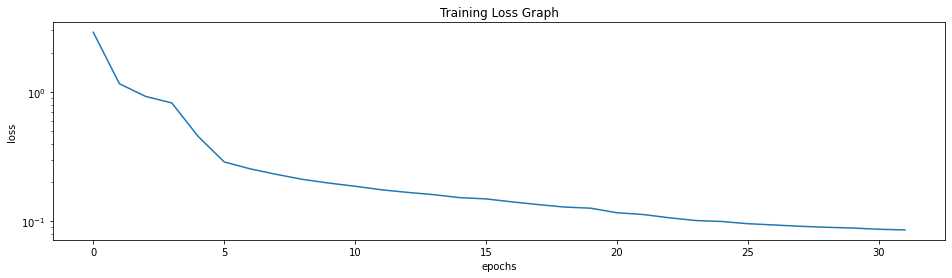

In [37]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [38]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


In [39]:
# VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])  # Data Scaling
VALIDATION_DF = sc.fit_transform(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])    # Data Scaling by MinMaxScaler
# VALIDATION_DF = sc.fit_transform(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])    # Data Scaling by Normalizer

In [40]:
boundary_check(VALIDATION_DF)

(False, False, False)

In [42]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]

  0%|          | 0/43112 [00:00<?, ?it/s]

# of valid windows: 43112


{'attack': 0.0,
 'ts': '2020-07-07 15:01:29',
 'given': tensor([[0.1624, 0.3216, 0.4998,  ..., 0.5881, 0.6792, 0.5285],
         [0.1629, 0.3222, 0.3433,  ..., 0.5883, 0.6792, 0.4242],
         [0.1627, 0.3222, 0.1668,  ..., 0.6021, 0.6792, 0.4902],
         ...,
         [0.1968, 0.2793, 0.1839,  ..., 0.3058, 0.6792, 0.4926],
         [0.1964, 0.2793, 0.0843,  ..., 0.2995, 0.6792, 0.5753],
         [0.1961, 0.2793, 0.0562,  ..., 0.2946, 0.6792, 0.7031]]),
 'answer': tensor([1.9704e-01, 2.7932e-01, 1.4883e-01, 3.0785e-04, 6.9733e-01, 1.1574e-03,
         1.4538e-01, 5.3671e-01, 3.6682e-01, 5.8456e-01, 7.7220e-01, 2.5860e-02,
         3.5278e-01, 7.9523e-01, 6.9320e-01, 5.1990e-01, 1.8437e-01, 0.0000e+00,
         3.6115e-01, 2.5350e-02, 9.9068e-01, 4.7701e-01, 1.0000e+00, 0.0000e+00,
         5.6869e-01, 9.9923e-01, 1.0455e-03, 5.9904e-01, 2.4930e-01, 3.2719e-01,
         6.8374e-01, 0.0000e+00, 6.9831e-01, 7.9270e-01, 1.0000e+00, 2.5823e-01,
         9.9327e-01, 4.7736e-02, 7.7104e-01

In [43]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["abnormal"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [44]:
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

In [45]:
CHECK_DIST.shape

(43112, 54)

In [46]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
print(ANOMALY_SCORE)

[0.04542787 0.04956502 0.05212862 ... 0.04443264 0.04398036 0.03792353]


In [47]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

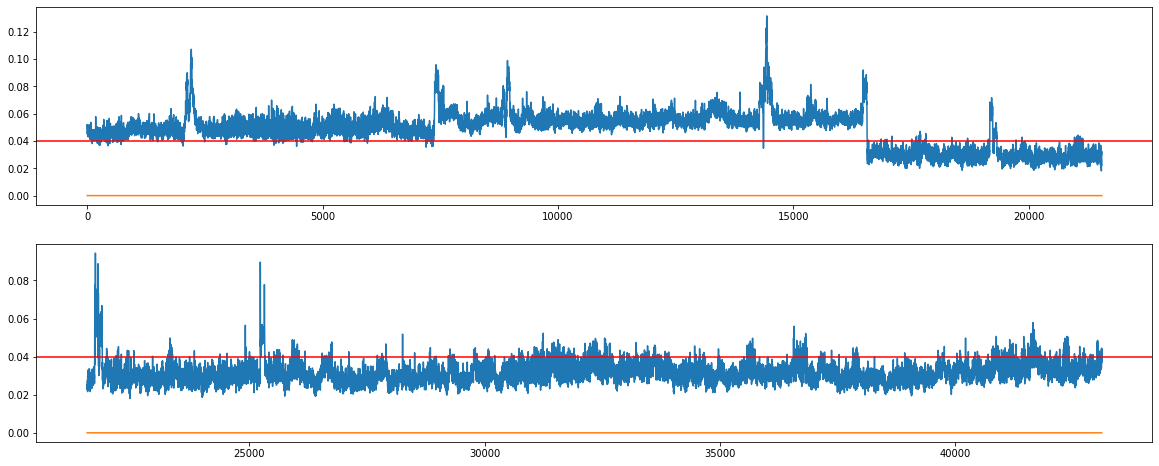

In [48]:
THRESHOLD = 0.04
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [49]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [50]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([1., 1., 1., ..., 1., 1., 0.], dtype=float32), (43112,))

In [52]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (43201,))

In [53]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [54]:
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

(43201,)

In [55]:
ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [56]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.075 (TaP: 0.040, TaR: 0.700)
# of detected anomalies: 2
Detected anomalies: ['4', '5']


In [57]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,...,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,...,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,...,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,...,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,...,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,...,824.82147,100.0,1.35666,9.62203,36.47460,11.78894,357.27722,361.14728,32.0,6.2809
92397,2020-07-31 12:29:57,420.08923,12.0,10,48.31848,-0.7498,97.19238,784.07184,28.03598,224,...,823.51697,100.0,1.35513,9.48747,36.47460,11.78894,357.29529,359.84521,32.0,6.3602
92398,2020-07-31 12:29:58,420.24258,12.0,10,48.31848,-0.6076,97.19238,786.83881,28.02642,208,...,824.82147,100.0,1.35666,9.57787,36.48986,11.78894,357.27722,360.60474,32.0,6.3742
92399,2020-07-31 12:29:59,420.24258,12.0,10,48.31848,-0.4618,97.19238,786.66138,28.03341,200,...,833.51904,100.0,1.35513,9.56291,36.48986,11.78894,357.80170,357.42188,32.0,6.2864


In [58]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C04,C05,C06,C07,C09,C10,C12,C13,C15,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.828325,0.225882,0.000999,0.318761,0.010417,0.139867,0.198263,0.808607,0.899123,...,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.828325,0.171634,0.000999,0.300187,0.010417,0.137445,0.195142,0.808607,0.895009,...,0.680584,0.0,0.317842,0.450701,0.230344,0.944440,0.223121,0.198499,0.26162,0.650106
2,0.272825,0.828325,0.166747,0.000930,0.298514,0.010417,0.137227,0.192253,0.808607,0.896677,...,0.678007,0.0,0.318290,0.451229,0.229791,0.944440,0.220223,0.196880,0.26162,0.644285
3,0.273182,0.828325,0.158478,0.000992,0.353980,0.010417,0.190063,0.193118,0.808607,0.894805,...,0.675769,0.0,0.318335,0.449470,0.229736,0.944440,0.218893,0.193823,0.26162,0.583093
4,0.272773,0.828325,0.174269,0.000998,0.370123,0.010417,0.266280,0.189690,0.807223,0.899709,...,0.682626,0.0,0.317891,0.450884,0.229731,0.944440,0.212932,0.198888,0.26162,0.523348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,0.619520,0.073426,0.532147,0.998079,0.476720,0.017489,0.358745,0.745671,0.199386,0.419343,...,0.596406,1.0,0.319337,0.285888,0.790598,0.083339,0.466152,0.485809,0.26162,0.622130
92397,0.619561,0.073426,0.581096,0.998079,0.446527,0.016853,0.386044,0.748083,0.199385,0.416854,...,0.595956,1.0,0.318439,0.281450,0.790543,0.083339,0.466370,0.482229,0.26162,0.658390
92398,0.620899,0.073426,0.639210,0.998079,0.474916,0.015748,0.453718,0.748445,0.199385,0.427714,...,0.596761,1.0,0.319252,0.284110,0.796619,0.083339,0.466330,0.484406,0.26162,0.666539
92399,0.621033,0.073426,0.699587,0.998079,0.475741,0.015116,0.563381,0.747269,0.199385,0.421857,...,0.602505,1.0,0.318431,0.283862,0.797227,0.083339,0.468106,0.474004,0.26162,0.638988


In [59]:
boundary_check(TEST_DF)

(True, True, False)

In [60]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]

  0%|          | 0/358715 [00:00<?, ?it/s]

# of valid windows: 358448


{'attack': 0.0,
 'ts': '2020-07-07 15:01:29',
 'given': tensor([[0.1624, 0.3216, 0.4998,  ..., 0.5881, 0.6792, 0.5285],
         [0.1629, 0.3222, 0.3433,  ..., 0.5883, 0.6792, 0.4242],
         [0.1627, 0.3222, 0.1668,  ..., 0.6021, 0.6792, 0.4902],
         ...,
         [0.1968, 0.2793, 0.1839,  ..., 0.3058, 0.6792, 0.4926],
         [0.1964, 0.2793, 0.0843,  ..., 0.2995, 0.6792, 0.5753],
         [0.1961, 0.2793, 0.0562,  ..., 0.2946, 0.6792, 0.7031]]),
 'answer': tensor([1.9704e-01, 2.7932e-01, 1.4883e-01, 3.0785e-04, 6.9733e-01, 1.1574e-03,
         1.4538e-01, 5.3671e-01, 3.6682e-01, 5.8456e-01, 7.7220e-01, 2.5860e-02,
         3.5278e-01, 7.9523e-01, 6.9320e-01, 5.1990e-01, 1.8437e-01, 0.0000e+00,
         3.6115e-01, 2.5350e-02, 9.9068e-01, 4.7701e-01, 1.0000e+00, 0.0000e+00,
         5.6869e-01, 9.9923e-01, 1.0455e-03, 5.9904e-01, 2.4930e-01, 3.2719e-01,
         6.8374e-01, 0.0000e+00, 6.9831e-01, 7.9270e-01, 1.0000e+00, 2.5823e-01,
         9.9327e-01, 4.7736e-02, 7.7104e-01

In [61]:
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

In [62]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

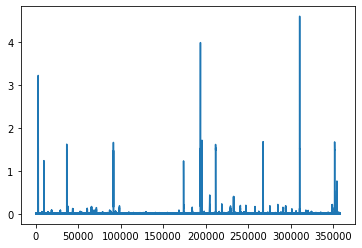

In [70]:
plt.plot(ANOMALY_SCORE)

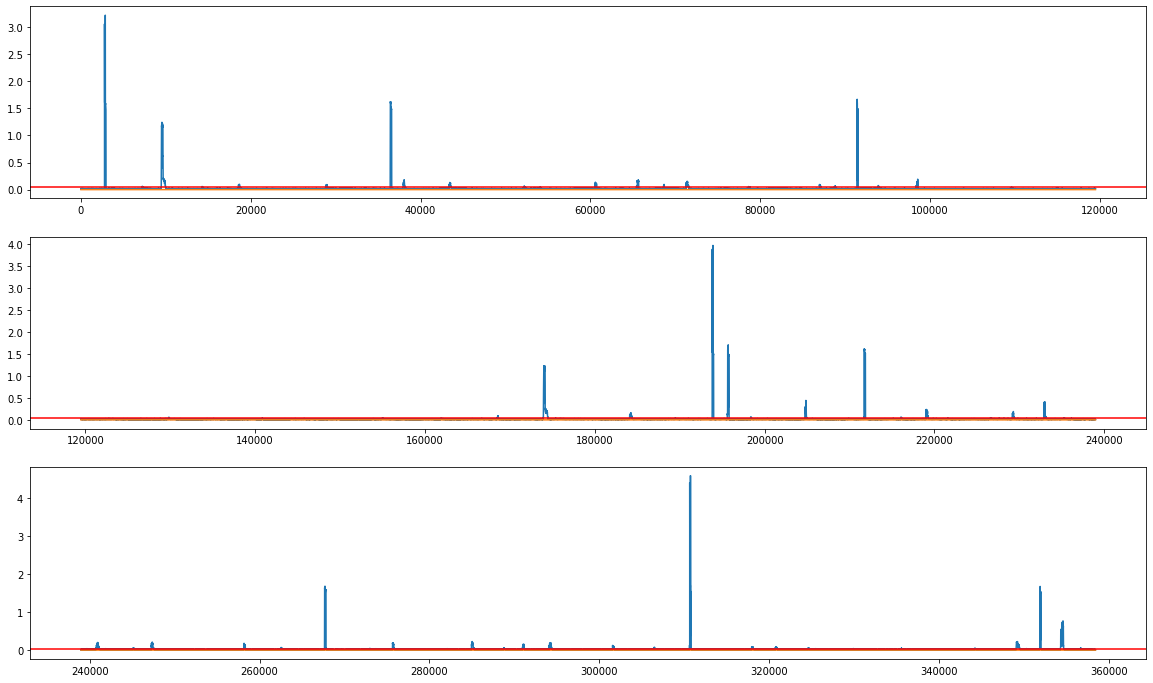

In [63]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [64]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (358448,))

In [67]:
submission = pd.read_csv('data/sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,time,attack
time,,
2020-07-09 15:00:00,2020-07-09 15:00:00,0.0
2020-07-09 15:00:01,2020-07-09 15:00:01,0.0
2020-07-09 15:00:02,2020-07-09 15:00:02,0.0
2020-07-09 15:00:03,2020-07-09 15:00:03,0.0
2020-07-09 15:00:04,2020-07-09 15:00:04,0.0
...,...,...
2020-07-31 12:29:56,2020-07-31 12:29:56,0.0
2020-07-31 12:29:57,2020-07-31 12:29:57,0.0
2020-07-31 12:29:58,2020-07-31 12:29:58,0.0


In [ ]:
submission.to_csv('baseline.csv', index=False)

In [ ]:
from google.colab import files
files.download('baseline.csv')